# Walmart Trip Type Classification
### Capstone Project - 1
### By: * Rajesh Dharmarajan *
******************
_This is my first capstone project for Springboard Career Track. This is a classification problem with Data from Walmart to predict the Trip Type. This is orginally from a Kaggle competition_

** Overview **


Walmart uses both art and science to continually make progress on their core mission of better understanding and serving their customers. One way Walmart is able to improve customers' shopping experiences is by segmenting their store visits into different trip types. 

Whether they're on a last minute run for new puppy supplies or leisurely making their way through a weekly grocery list, classifying trip types enables Walmart to create the best shopping experience for every customer.

Currently, Walmart's trip types are created from a combination of existing customer insights ("art") and purchase history data ("science"). 

The challenge here is to classify customer trips using only a transactional dataset of the items they've purchased.

https://www.kaggle.com/c/walmart-recruiting-trip-type-classification


In [1]:
import pandas as pd
import tkinter
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import math
#matplotlib inline
#%matplotlib notebook
import seaborn as sns
pd.set_option('display.max_columns', None)

** Read the file **

In [2]:
df_walmart_raw = pd.read_csv('wm_train.csv')

**Data fields**

* TripType - a categorical id representing the type of shopping trip the customer made. This is the ground truth that you are predicting. TripType_999 is an "other" category.
* VisitNumber - an id corresponding to a single trip by a single customer
* Weekday - the weekday of the trip
* Upc - the UPC number of the product purchased
* ScanCount - the number of the given item that was purchased. A negative value indicates a product return.
* DepartmentDescription - a high-level description of the item's department
* FinelineNumber - a more refined category for each of the products, created by Walmart

In [3]:
df_walmart_raw.head(5)

TripType  VisitNumber Weekday           Upc  ScanCount  \
0       999            5  Friday  6.811315e+10         -1   
1        30            7  Friday  6.053882e+10          1   
2        30            7  Friday  7.410811e+09          1   
3        26            8  Friday  2.238404e+09          2   
4        26            8  Friday  2.006614e+09          2   

   DepartmentDescription  FinelineNumber  
0     FINANCIAL SERVICES          1000.0  
1                  SHOES          8931.0  
2          PERSONAL CARE          4504.0  
3  PAINT AND ACCESSORIES          3565.0  
4  PAINT AND ACCESSORIES          1017.0

In [4]:
df_walmart_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 647054 entries, 0 to 647053
Data columns (total 7 columns):
TripType                 647054 non-null int64
VisitNumber              647054 non-null int64
Weekday                  647054 non-null object
Upc                      642925 non-null float64
ScanCount                647054 non-null int64
DepartmentDescription    645693 non-null object
FinelineNumber           642925 non-null float64
dtypes: float64(2), int64(3), object(2)
memory usage: 34.6+ MB




Lets look at the data
****

In [5]:
unique_trips = len(df_walmart_raw.VisitNumber.unique())# number of unique trips - 95,674

In [6]:
unique_UPC = len(df_walmart_raw.Upc.unique())# number of unique UPC - 97,715

In [7]:
unique_FilelineNumber = len(df_walmart_raw.FinelineNumber.unique()) # number of unique FinelineNumber - 5,196

In [8]:
unique_TripTypes = len(df_walmart_raw.TripType.unique())#38 different types of Trips

In [9]:
unique_departments = len(df_walmart_raw.DepartmentDescription.unique())#69 different types of departments

In [10]:
# Check if there are any rows where UPC is present, but Department Description is not present
df_walmart_raw[((df_walmart_raw.DepartmentDescription.isnull()) & (df_walmart_raw.Upc.notnull()))]

Empty DataFrame
Columns: [TripType, VisitNumber, Weekday, Upc, ScanCount, DepartmentDescription, FinelineNumber]
Index: []

In [11]:
# Check if there are any rows where UPC is present, but Fineline Number is not present
df_walmart_raw[((df_walmart_raw.FinelineNumber.isnull()) & (df_walmart_raw.Upc.notnull()))]

Empty DataFrame
Columns: [TripType, VisitNumber, Weekday, Upc, ScanCount, DepartmentDescription, FinelineNumber]
Index: []

In [12]:
#let us look at rows that have null UPC
df_null_upc=df_walmart_raw[(df_walmart_raw.Upc.isnull())]

In [13]:
len(df_null_upc)#a total of 4,129 rows have null UPC

4129

In [14]:
#let us look at a few rows
df_null_upc.head(10)

TripType  VisitNumber Weekday  Upc  ScanCount DepartmentDescription  \
25          26            8  Friday  NaN          1                   NaN   
548         27          259  Friday  NaN          3                   NaN   
549         27          259  Friday  NaN          1                   NaN   
959        999          409  Friday  NaN         -1                   NaN   
1116        39          479  Friday  NaN          1                   NaN   
1134       999          484  Friday  NaN         -2                   NaN   
1135       999          484  Friday  NaN         -2                   NaN   
1155        44          496  Friday  NaN          1           PHARMACY RX   
1216         5          521  Friday  NaN          1           PHARMACY RX   
1373         5          585  Friday  NaN          1           PHARMACY RX   

      FinelineNumber  
25               NaN  
548              NaN  
549              NaN  
959              NaN  
1116             NaN  
1134             NaN  
1135             NaN  
1155             NaN  
1216             NaN  
1373             NaN

From the above, we see that the `FinelineNumber` is also $null$ when the `UPC` is null. There are some rows where `DepartmentDescription` is present and all of the null UPC rows have a valid `ScanCount` . Let us check if there are any other departments other than Pharmacy in these null UPC data.

In [15]:
df_null_upc[((df_null_upc.DepartmentDescription.notnull()) & 
             (df_null_upc.DepartmentDescription != 'PHARMACY RX'))]

Empty DataFrame
Columns: [TripType, VisitNumber, Weekday, Upc, ScanCount, DepartmentDescription, FinelineNumber]
Index: []

***
Check if these data with null UPC numbers have a valid Fineline Number

In [16]:
df_null_upc[(df_null_upc.FinelineNumber.notnull()) ]

Empty DataFrame
Columns: [TripType, VisitNumber, Weekday, Upc, ScanCount, DepartmentDescription, FinelineNumber]
Index: []

In [17]:
#let us look at the distribution of the TripTypes when UPC is null
df_null_upc.TripType.value_counts()

5      2583
999     352
40      193
39      135
25      116
9        82
8        78
37       68
44       63
42       50
36       49
24       48
38       40
43       38
32       31
7        31
15       21
41       18
33       16
30       15
27       13
34       12
22       11
35        9
21        7
20        7
18        6
28        6
3         5
4         5
29        5
31        4
26        4
12        4
6         3
19        1
Name: TripType, dtype: int64

Remove these rows from the data since, without knowning what the customer bought or returned, the trip cannot be classified. So, discard these rows

In [18]:
#df_walmart_1st_cleanse = df_walmart_raw[(df_walmart_raw.Upc.notnull())&(df_walmart_raw.DepartmentDescription.notnull())]
df_walmart_1st_cleanse = df_walmart_raw[(df_walmart_raw.Upc.notnull())]

In [19]:
df_walmart_1st_cleanse[df_walmart_1st_cleanse['VisitNumber']==8784]

TripType  VisitNumber   Weekday           Upc  ScanCount  \
28348        40         8784  Saturday  8.402160e+10          1   
28349        40         8784  Saturday  3.890000e+09          1   
28350        40         8784  Saturday  2.700038e+09          1   
28351        40         8784  Saturday  4.133344e+09          1   
28352        40         8784  Saturday  8.200073e+09          1   
28353        40         8784  Saturday  7.342000e+09          1   
28354        40         8784  Saturday  4.510006e+09          1   
28355        40         8784  Saturday  1.312000e+09          1   
28356        40         8784  Saturday  2.310001e+09          2   
28357        40         8784  Saturday  7.874209e+09          1   
28358        40         8784  Saturday  4.790051e+09          1   
28359        40         8784  Saturday  3.810033e+09          1   
28360        40         8784  Saturday  2.310002e+09          5   
28361        40         8784  Saturday  4.222281e+09          2   
28362        40         8784  Saturday  7.874209e+09          1   
28363        40         8784  Saturday  7.432300e+09          1   
28364        40         8784  Saturday  6.233894e+09          1   

          DepartmentDescription  FinelineNumber  
28348                HOME DECOR          1629.0  
28349         GROCERY DRY GOODS          2757.0  
28350         GROCERY DRY GOODS          2301.0  
28351       IMPULSE MERCHANDISE           902.0  
28352          LIQUOR,WINE,BEER          1111.0  
28353                     DAIRY          1353.0  
28354               DSD GROCERY          2536.0  
28355              FROZEN FOODS          1801.0  
28356         PETS AND SUPPLIES           610.0  
28357           PRE PACKED DELI          7199.0  
28358         GROCERY DRY GOODS          2452.0  
28359         PETS AND SUPPLIES           410.0  
28360         PETS AND SUPPLIES           610.0  
28361           PRE PACKED DELI          7506.0  
28362         GROCERY DRY GOODS          2302.0  
28363               DSD GROCERY          2704.0  
28364  HOUSEHOLD CHEMICALS/SUPP          8945.0

In [20]:
no_of_obs = len(df_walmart_1st_cleanse) # 645,693 observations after dropping the ones with null UPCs

In [21]:
unique_nonnull_trips = len(df_walmart_1st_cleanse.VisitNumber.unique())# number of unique trips - 95,674

In [22]:
df_walmart_1st_cleanse.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 642925 entries, 0 to 647053
Data columns (total 7 columns):
TripType                 642925 non-null int64
VisitNumber              642925 non-null int64
Weekday                  642925 non-null object
Upc                      642925 non-null float64
ScanCount                642925 non-null int64
DepartmentDescription    642925 non-null object
FinelineNumber           642925 non-null float64
dtypes: float64(2), int64(3), object(2)
memory usage: 39.2+ MB


***
** Analyze UPCs that occur just once **

In [23]:
#get all the UPCs that show up just once 
count_series = df_walmart_1st_cleanse.Upc.value_counts()
count_series = count_series[count_series.values<2]

In [24]:
#get the UPCs into a list
upc_once_occurs_list = count_series.axes[0]

In [25]:
#get the list of VisitNumbers that have the UPCs that occcur just once
upc_once_visits = df_walmart_1st_cleanse[df_walmart_1st_cleanse.Upc.isin(upc_once_occurs_list)].VisitNumber.unique()

In [26]:
len(upc_once_occurs_list)
# there are 37,080 UPCs that occur only once, total unique UPCs - 97,715

37080

In [27]:
len(upc_once_visits)
#22,415 visits contain UPCs that occur only once, total number of visits in this data 95,674

22415

***

### Check the distribution of UPC and Department

In [28]:
upc_counts = pd.DataFrame(df_walmart_raw.groupby('Upc').size().sort_values(ascending=False))#.head(10000).sum() #.plot()
#100-65845
#1000-170277
#10000-390185

In [29]:
upc_counts=upc_counts.reset_index().reset_index()
upc_counts.columns=['ixnum','Upc','Counts']

In [30]:
upc_counts['str_upc']=upc_counts['Upc'].apply(str)
upc_counts['str_upc']=upc_counts.str_upc.map(lambda x : x[:-2])
upc_counts['cum_sum']=upc_counts.Counts.cumsum()

In [31]:
upc_counts.head(5)

ixnum           Upc  Counts      str_upc  cum_sum
0      0  4.011000e+03    7657         4011     7657
1      1  6.053886e+10    2501  60538862097    10158
2      2  7.874235e+09    2067   7874235186    12225
3      3  7.874235e+09    1883   7874235187    14108
4      4  4.046000e+03    1652         4046    15760

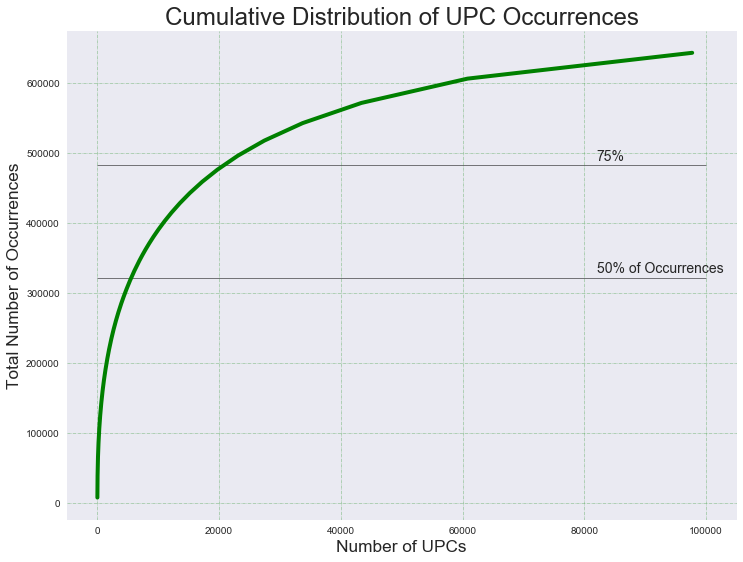

In [32]:
f,ax=plt.subplots(figsize=(12,9))
plt.plot(upc_counts.Counts.cumsum(),linewidth=4,color='g')#
plt.grid(True, 'major','y', ls='-.', lw=.5, c='g', alpha=.5)
plt.grid(True, 'major','x', ls='-.', lw=.5, c='g', alpha=.5)
plt.ylabel('Total Number of Occurrences',fontsize='x-large')
plt.xlabel('Number of UPCs',fontsize='x-large')
plt.hlines(upc_counts.Counts.sum()/2,0,100000,linewidth=0.5)
plt.text(82000,330000,'50% of Occurrences',fontsize=14)
plt.hlines(upc_counts.Counts.sum()*0.75,0,100000,linewidth=0.5)
plt.text(82000,490000,'75%',fontsize=14)
plt.title('Cumulative Distribution of UPC Occurrences',fontsize=24)
plt.show()

In [33]:
upc_occ_sr=upc_counts[['Counts']].groupby((upc_counts.ixnum+10000)//10000*10000).sum()

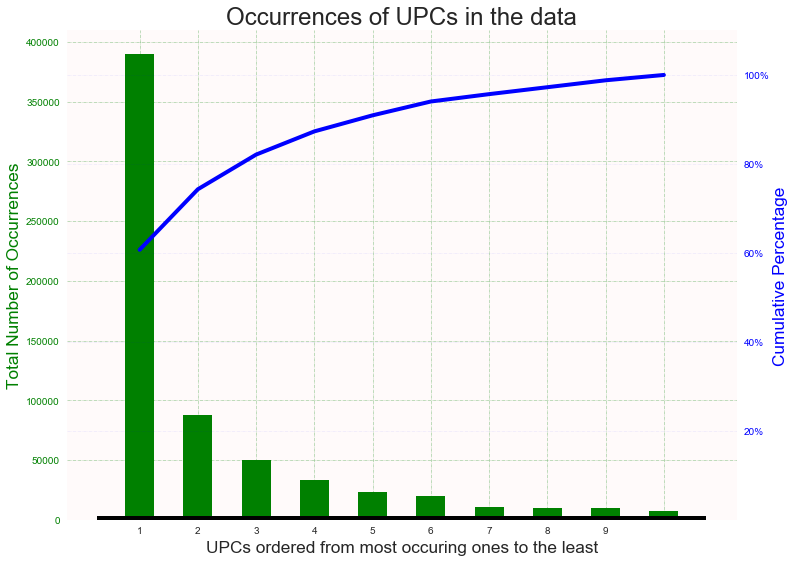

In [34]:
f,ax=plt.subplots(figsize=(12,9))
width=0.5
ind=np.arange(10)
ax.set_facecolor(color='snow')
ax.bar(ind, upc_occ_sr.values,width,color='g')
ax.set_ylabel('Total Number of Occurrences',fontsize='x-large',color='g')
ax.set_xlabel('UPCs ordered from most occuring ones to the least',fontsize='x-large')
ax.grid(True, 'major','y', ls='-.', lw=.5, c='g', alpha=.5)
ax.grid(True, 'major','x', ls='-.', lw=.5, c='g', alpha=.5)
ax.tick_params('y', colors='g')
plt.xticks(ind,np.arange(1,10,1))
plt.title('Occurrences of UPCs in the data',fontsize=24)

ax2=ax.twinx()
ax2.plot(ind,(upc_occ_sr.cumsum()/upc_occ_sr.sum()),color='blue',linewidth=4)
ax2.grid(True, 'major','y', ls='-.', lw=.5, c='blue', alpha=.1)
ax2.grid(True, 'major','x', ls='-.', lw=.5, c='blue', alpha=.1)
ax2.set_ylabel('Cumulative Percentage',fontsize='x-large',color='blue')
ax2.set_yticklabels(['','20%','40%','60%','80%','100%'])
ax2.tick_params('y', colors='blue')
ax2.set_ylim(0,1.1)
plt.hlines(0,ax2.get_xlim()[0],ax2.get_xlim()[1],color='k',linewidth=8)
plt.show()

In [35]:
dept_counts = pd.DataFrame(df_walmart_raw.groupby('DepartmentDescription').size().sort_values(ascending=False))
dept_counts=dept_counts.reset_index().reset_index()
dept_counts.columns=['ixnum','Dept','Count']

In [36]:
dept_counts.head(5)

ixnum               Dept  Count
0      0  GROCERY DRY GOODS  70402
1      1        DSD GROCERY  68332
2      2            PRODUCE  51115
3      3              DAIRY  43820
4      4      PERSONAL CARE  41969

In [37]:
dept_occ_sr=dept_counts[['Count']].groupby((dept_counts.ixnum+10)//10*10).sum()

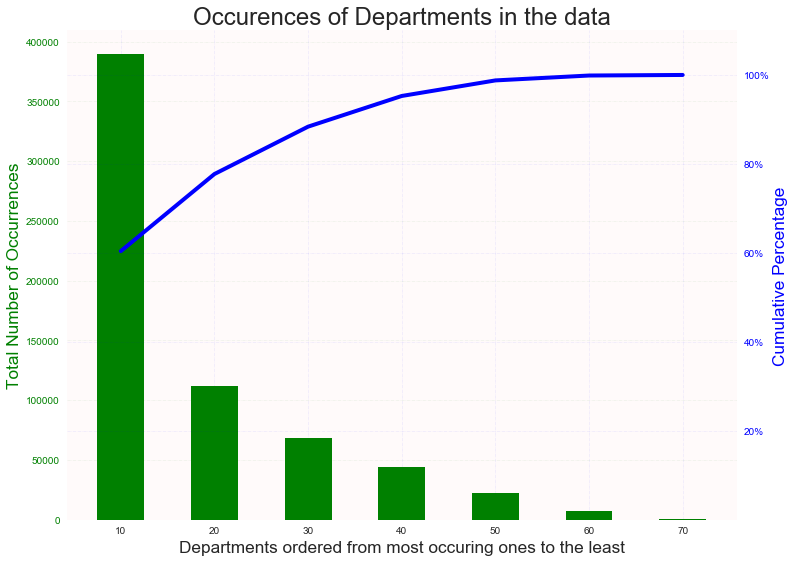

In [38]:
f,ax=plt.subplots(figsize=(12,9))
width=0.5
ind=np.arange(7)
ax.set_facecolor(color='snow')
ax.bar(ind, dept_occ_sr.values,width,color='green')
ax.grid(True, 'major','y', ls='-.', lw=.5, c='green', alpha=.1)
ax.grid(False, 'major','x', ls='-.', lw=.5, c='blue', alpha=.1)
ax.set_ylabel('Total Number of Occurrences',fontsize='x-large',color='g')
ax.tick_params('y', colors='g')
plt.xlabel('Departments ordered from most occuring ones to the least',fontsize='x-large')
plt.xticks(ind,np.arange(10,80,10))
plt.title('Occurences of Departments in the data',fontsize=24)

ax2=ax.twinx()
ax2.plot(ind,(dept_occ_sr.cumsum()/dept_occ_sr.sum()),color='blue',linewidth=4)
ax2.grid(True, 'major','y', ls='-.', lw=.5, c='blue', alpha=.1)
ax2.grid(False, 'major','x', ls='-.', lw=.5, c='blue', alpha=.1)
ax2.set_ylabel('Cumulative Percentage',fontsize='x-large',color='blue')
ax2.set_yticklabels(['','20%','40%','60%','80%','100%'])
ax2.tick_params('y', colors='blue')
ax2.set_ylim(0,1.1)
#plt.hlines(0,ax2.get_xlim()[0],ax2.get_xlim()[1],color='k',linewidth=4)

plt.show()

In [39]:
flno_counts=pd.DataFrame(df_walmart_raw.groupby('FinelineNumber').size().sort_values(ascending=False))
flno_counts=flno_counts.reset_index().reset_index()
flno_counts.columns = ['ixnum','FinelineNumber','TotOcc']

In [40]:
flno_counts['GrpBy500']=((flno_counts.ixnum+500)//500)*500
flno_sum_sr=flno_counts[['GrpBy500','TotOcc']].groupby('GrpBy500').sum()
flno_sum_sr=flno_sum_sr.reset_index()
flno_sum_sr['CumSum']=(flno_sum_sr.TotOcc.cumsum()/flno_sum_sr.TotOcc.sum())*100

In [41]:
flno_sum_sr.head()

GrpBy500  TotOcc     CumSum
0       500  375919  58.470117
1      1000  109800  75.548314
2      1500   61269  85.078042
3      2000   36976  90.829257
4      2500   23166  94.432477

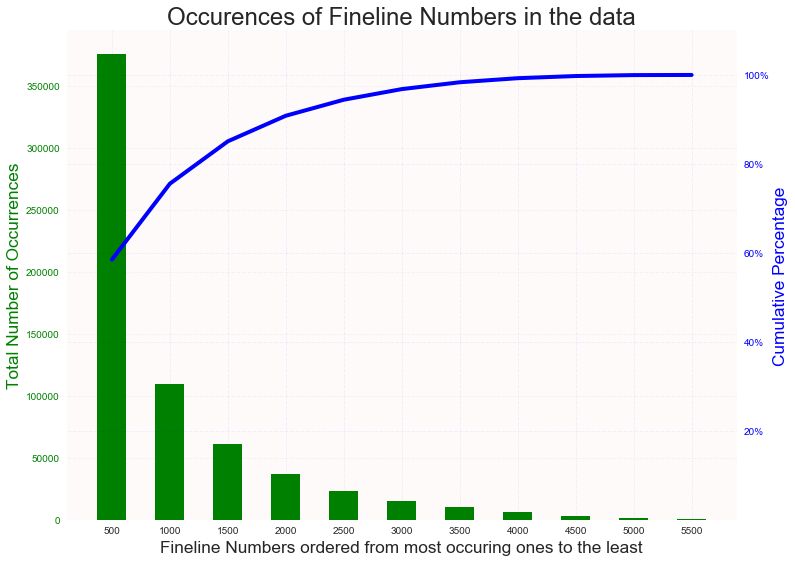

In [42]:
f,ax=plt.subplots(figsize=(12,9))
width=0.5
ax.set_facecolor(color='snow')
ind=np.arange(len(flno_sum_sr))
ax.bar(ind, flno_sum_sr.TotOcc,width,color='green')
ax.set_ylabel('Total Number of Occurrences',fontsize='x-large',color='g')
ax.tick_params('y', colors='g')
ax.grid(True, 'major','y', ls='-.', lw=.5, c='green', alpha=.1)
ax.grid(False, 'major','x', ls='-.', lw=.5, c='blue', alpha=.1)
plt.xlabel('Fineline Numbers ordered from most occuring ones to the least',fontsize='x-large')
plt.xticks(ind,np.arange(500,6000,500))
plt.title('Occurences of Fineline Numbers in the data',fontsize=24)

ax2=ax.twinx()
ax2.plot(ind,flno_sum_sr.CumSum,color='blue',linewidth=4)
ax2.grid(True, 'major','y', ls='-.', lw=.5, c='blue', alpha=.1)
ax2.grid(False, 'major','x', ls='-.', lw=.5, c='blue', alpha=.1)
ax2.set_ylabel('Cumulative Percentage',fontsize='x-large',color='blue')
ax2.set_yticklabels(['','20%','40%','60%','80%','100%'])
ax2.tick_params('y', colors='blue')
ax2.set_ylim(0,110)

plt.show()

## Check if the  trip types are related to day of the Week

In [43]:
trip_types=df_walmart_1st_cleanse.TripType.unique()#.sort(axis=0) #.sort_values()

In [44]:
trip_types.sort(axis=0)

In [45]:
days_of_week=['Sunday','Monday','Tuesday','Wednesday','Thursday','Friday','Saturday']

In [46]:
df_days_triptype=pd.DataFrame(df_walmart_1st_cleanse[['Weekday','TripType']].groupby(['TripType','Weekday']).size())

In [47]:
df_days_triptype=df_days_triptype.unstack('Weekday',fill_value=0)

In [48]:
df_days_triptype.head()

0                                                  
Weekday  Friday Monday Saturday Sunday Thursday Tuesday Wednesday
TripType                                                         
3          1408    830     1167    901      760     860       896
4           150    111      164    151      106      96       118
5          1765   1464     1966   1558     1462    1468      1570
6           655    336      855    442      378     351       385
7          3233   3292     3571   4009     2859    2967      3237

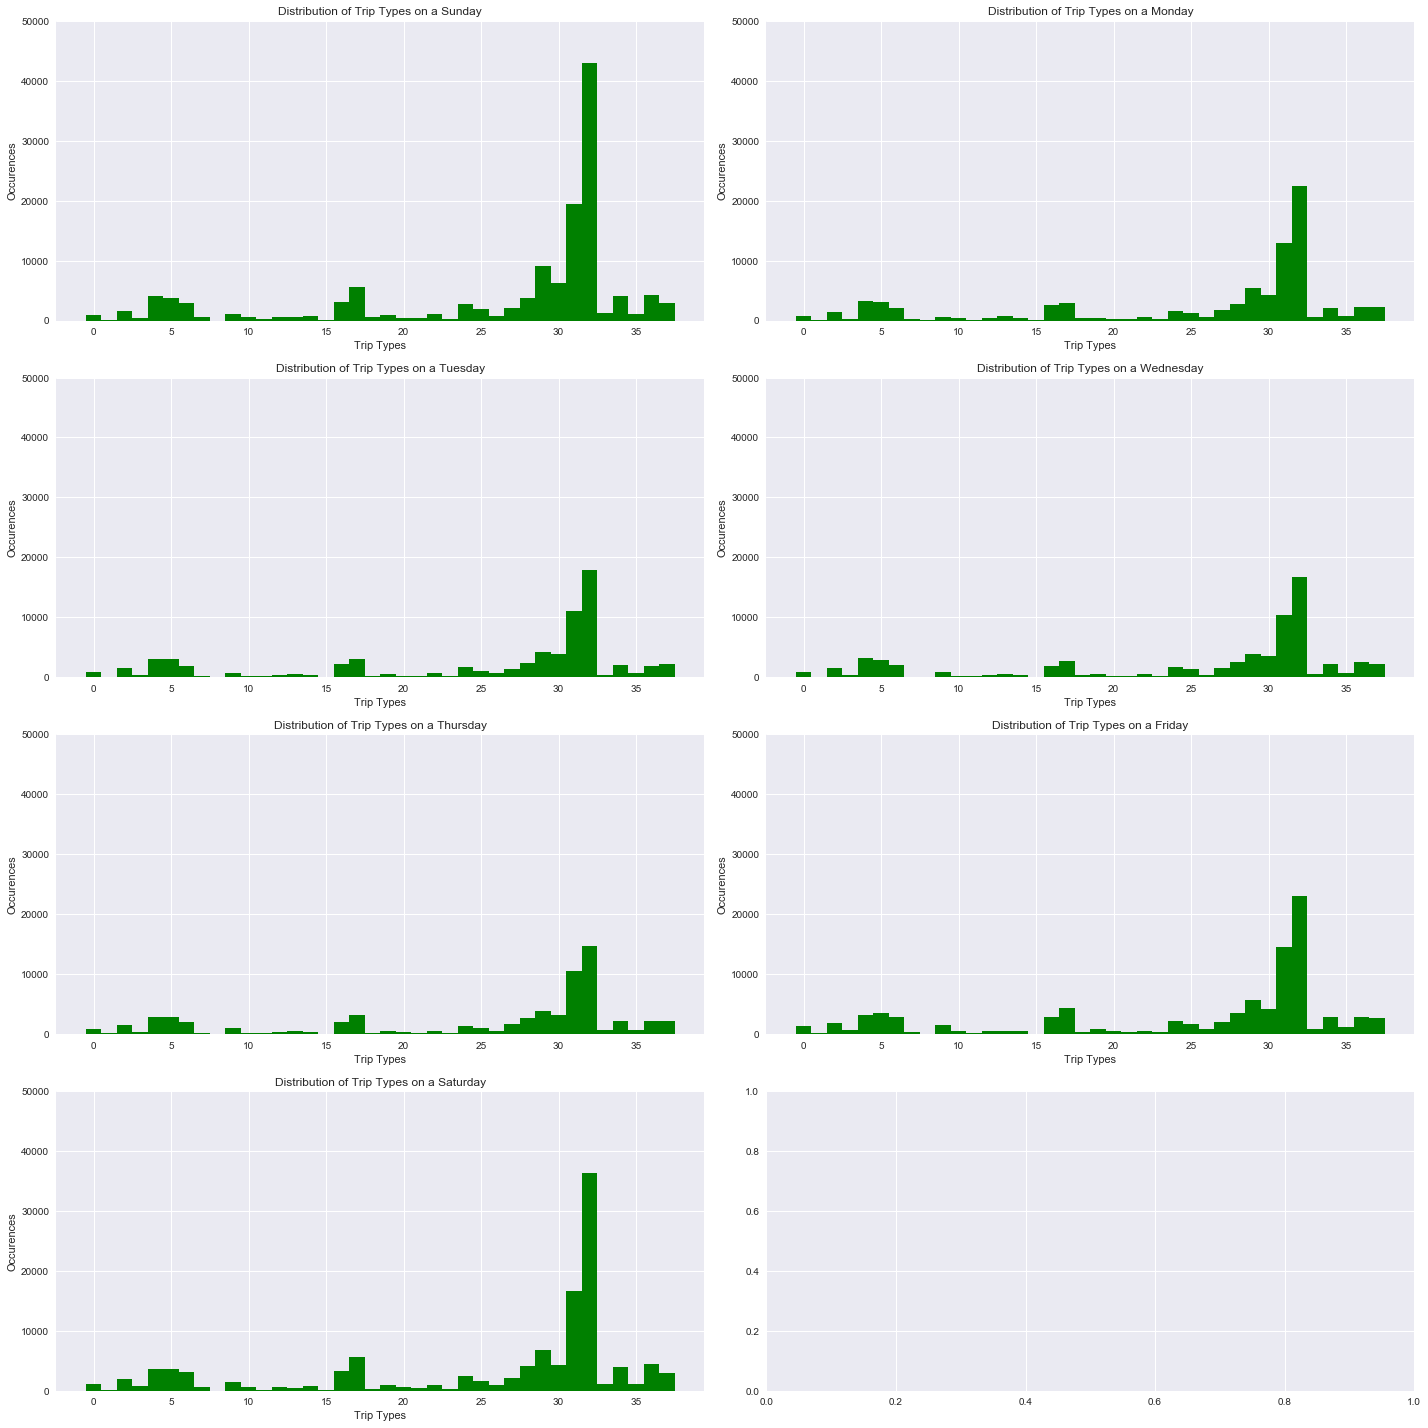

In [49]:
plt.rcParams["figure.figsize"] = (20,20)
fig, axes = plt.subplots(nrows=4, ncols=2)
ax0, ax1, ax2, ax3, ax4, ax5, ax6, ax7 = axes.flatten()
ind=np.arange(len(trip_types))
width=1.0
btm=0
tp=50000
clr='green'
ax0.bar(ind, df_days_triptype[[0][0]]['Sunday'].values,width,color=clr)
ax0.set_title('Distribution of Trip Types on a Sunday')
ax0.set_ylim(bottom=btm,top=tp,auto=False)
ax0.set_xlabel('Trip Types')
ax0.set_ylabel('Occurences')

ax1.bar(ind, df_days_triptype[[0][0]]['Monday'].values,width,color=clr)
ax1.set_title('Distribution of Trip Types on a Monday')
ax1.set_ylim(bottom=btm,top=tp,auto=False)
ax1.set_xlabel('Trip Types')
ax1.set_ylabel('Occurences')


ax2.bar(ind, df_days_triptype[[0][0]]['Tuesday'].values,width,color=clr)
ax2.set_title('Distribution of Trip Types on a Tuesday')
ax2.set_ylim(bottom=btm,top=tp,auto=False)
ax2.set_xlabel('Trip Types')
ax2.set_ylabel('Occurences')

ax3.bar(ind, df_days_triptype[[0][0]]['Wednesday'].values,width,color=clr)
ax3.set_title('Distribution of Trip Types on a Wednesday')
ax3.set_ylim(bottom=btm,top=tp,auto=False)
ax3.set_xlabel('Trip Types')
ax3.set_ylabel('Occurences')


ax4.bar(ind, df_days_triptype[[0][0]]['Thursday'].values,width,color=clr)
ax4.set_title('Distribution of Trip Types on a Thursday')
ax4.set_ylim(bottom=btm,top=tp,auto=False)
ax4.set_xlabel('Trip Types')
ax4.set_ylabel('Occurences')

ax5.bar(ind, df_days_triptype[[0][0]]['Friday'].values,width,color=clr)
ax5.set_title('Distribution of Trip Types on a Friday')
ax5.set_ylim(bottom=btm,top=tp,auto=False)
ax5.set_xlabel('Trip Types')
ax5.set_ylabel('Occurences')


ax6.bar(ind, df_days_triptype[[0][0]]['Saturday'].values,width,color=clr)
ax6.set_title('Distribution of Trip Types on a Saturday')
ax6.set_ylim(bottom=btm,top=tp,auto=False)
ax6.set_xlabel('Trip Types')
ax6.set_ylabel('Occurences')

fig.tight_layout()
plt.show()

***

# Data Wrangling

## Analyze the UPCs

`df_walmart_1st_cleanse` is the provided Walmart data without the Null UPCs.

#### About the UPC Number

A UPC number is made up of 12 digits. The manufacturer identification number is the first six digits of the UPC number. The next five digits are the item number. The last digit of the UPC code is called a check digit.

In [50]:
df_walmart_1st_cleanse.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 642925 entries, 0 to 647053
Data columns (total 7 columns):
TripType                 642925 non-null int64
VisitNumber              642925 non-null int64
Weekday                  642925 non-null object
Upc                      642925 non-null float64
ScanCount                642925 non-null int64
DepartmentDescription    642925 non-null object
FinelineNumber           642925 non-null float64
dtypes: float64(2), int64(3), object(2)
memory usage: 39.2+ MB


In [51]:
#convert UPCs to String
df_walmart_1st_cleanse.Upc = df_walmart_1st_cleanse.Upc.apply(str)
#drop the .0 from the end of the UPC
#upc_counts['str_upc']=upc_counts.str_upc.map(lambda x : x[:-2])
df_walmart_1st_cleanse.Upc=df_walmart_1st_cleanse.Upc.map(lambda x: x[:-2])
#the UPC numbers are of different lengths, store the lenghts in a column
df_walmart_1st_cleanse['UPCLen']=df_walmart_1st_cleanse.Upc.map(lambda x: len(x))

C:\Anac\lib\site-packages\pandas\core\generic.py:2999: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value
C:\Anac\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


In [52]:
df_walmart_1st_cleanse.head()

TripType  VisitNumber Weekday          Upc  ScanCount  \
0       999            5  Friday  68113152929         -1   
1        30            7  Friday  60538815980          1   
2        30            7  Friday   7410811099          1   
3        26            8  Friday   2238403510          2   
4        26            8  Friday   2006613744          2   

   DepartmentDescription  FinelineNumber  UPCLen  
0     FINANCIAL SERVICES          1000.0      11  
1                  SHOES          8931.0      11  
2          PERSONAL CARE          4504.0      10  
3  PAINT AND ACCESSORIES          3565.0      10  
4  PAINT AND ACCESSORIES          1017.0      10

In [53]:
# Distribution of UPC lengths
df_walmart_1st_cleanse.UPCLen.value_counts()

10    433341
11    168418
4      29745
12      8463
9       2166
8        412
5        372
3          7
7          1
Name: UPCLen, dtype: int64

From the above, we see that UPC numbers are of varying length, from just 3 digit to 12 digits. Lets look at a few of these

In [54]:
df_walmart_1st_cleanse[df_walmart_1st_cleanse['UPCLen']==12].head(3)

TripType  VisitNumber Weekday           Upc  ScanCount  \
48        21           15  Friday  501138607481          1   
50        21           15  Friday  501138610338          1   
58        42           19  Friday  692656840005          1   

   DepartmentDescription  FinelineNumber  UPCLen  
48    FABRICS AND CRAFTS          1309.0      12  
50    FABRICS AND CRAFTS          1309.0      12  
58    FABRICS AND CRAFTS           397.0      12

In [55]:
df_walmart_1st_cleanse[df_walmart_1st_cleanse['UPCLen']==11].head(3)

TripType  VisitNumber Weekday          Upc  ScanCount  \
0        999            5  Friday  68113152929         -1   
1         30            7  Friday  60538815980          1   
11        26            8  Friday  88679300501          2   

    DepartmentDescription  FinelineNumber  UPCLen  
0      FINANCIAL SERVICES          1000.0      11  
1                   SHOES          8931.0      11  
11  PAINT AND ACCESSORIES          3504.0      11

In [56]:
df_walmart_1st_cleanse[df_walmart_1st_cleanse['UPCLen']==10].head(3)

TripType  VisitNumber Weekday         Upc  ScanCount  \
2        30            7  Friday  7410811099          1   
3        26            8  Friday  2238403510          2   
4        26            8  Friday  2006613744          2   

   DepartmentDescription  FinelineNumber  UPCLen  
2          PERSONAL CARE          4504.0      10  
3  PAINT AND ACCESSORIES          3565.0      10  
4  PAINT AND ACCESSORIES          1017.0      10

In [57]:
df_walmart_1st_cleanse[df_walmart_1st_cleanse['UPCLen']==7].head(3)

TripType  VisitNumber   Weekday      Upc  ScanCount  \
431366        42       128507  Thursday  5080744          1   

       DepartmentDescription  FinelineNumber  UPCLen  
431366    FABRICS AND CRAFTS          1300.0       7

In [58]:
df_walmart_1st_cleanse[df_walmart_1st_cleanse['UPCLen']==3].head(3)

TripType  VisitNumber   Weekday  Upc  ScanCount DepartmentDescription  \
429744        40       127954  Thursday  834          1                BAKERY   
429745        40       127954  Thursday  834          2                BAKERY   
448895        39       134005    Friday  834          1                BAKERY   

        FinelineNumber  UPCLen  
429744          5016.0       3  
429745          5016.0       3  
448895          5016.0       3

<div class="alert alert-success">

<p>
From what we see here, though the header of the column says `Upc`, there are multiple variations of the UPC number. To proceed further, we can make some $assumptions$ like the following regarding how the data was created 
<ul>
<li> checkdigit was dropped
<li> leading zeros were dropped
<li> items between 3000 and 4000 are [PLU](https://en.wikipedia.org/wiki/Price_look-up_code) codes
</ul>
<br>
However, since we do not know which of these are true and, there may be other changes that were done to the UPC numbers, we will use the given UPC number as is as features to classify the trip. There are a large number of UPCs, the total number of UPCs are approximately 98,000. <strong>The distribution of UPC numbers is skewed.</strong> 37,080 UPCs occur only once and 20 % of the UPCs occur in approx. 75% of the data.
</p>

<p> Similar behavior is noted in Fineline Number and Departments, i.e. a relatively small % of data is found in a large number of observations. Considering this fact, we will use the <strong>following as the features</strong> for each Visit
</p>
<ol>
<li> Number of items bought 
<li> Day of the week
<li> All the Departments
<li> The top 10% of UPC
<li> The top 30% of Fineline Number
</ol>
<p>
With these features, we will have around 12,000 features.
</p>
</div>

## Build a DataFrame where the features of a Visit are in a single observation


Build a DataFrame with the visits and the following features
<ol>
<li> Number of items bought
<li> Day of the week
<li> Departments of the items bought in the visit
</ol>

In [59]:
# get all the VisitNumbers
df_visits = pd.DataFrame(df_walmart_1st_cleanse.VisitNumber.value_counts().axes[0])
df_visits.columns=['VisitNumber']
# get the number of items scanned in each VisitNumber, note that this is not same as
# the sum of quantity of items bought. i.e. if there are two items scanned
# item 1 - scanned qty 1 and item 2 - scanned qty -3, this will have 2 as the value
df_visits['no_of_items']=df_walmart_1st_cleanse.VisitNumber.value_counts().values 

In [60]:
#check if there are 94247 visits
len(df_visits)

94247

In [61]:
'''
this function builds a vector of department descriptions for each visit
*** input ***  
dept_dict - dictionary of department descriptions - all set to zero
dept_series - a Series of all the department description in the visit
scan_series - a Series of all the scan count ordered in the same way as department description
*** output ***
numpy array of the scan counts, i.e., total scanned items for a particular department
'''
def buildDeptVector(dept_dict, dept_series, scan_series):
    for i in range(0,len(dept_series)):
        if (dept_series.iloc[i] in dept_dict):
            dept_dict[dept_series.iloc[i]] = dept_dict[dept_series.iloc[i]]+scan_series.iloc[i]
    return list(dept_dict.values())


In [62]:
# build a list of all Department Descriptions and sort them
dept_list = df_walmart_1st_cleanse.DepartmentDescription.unique()
dept_list.sort()

In [63]:
len(dept_list),dept_list

(68, array(['1-HR PHOTO', 'ACCESSORIES', 'AUTOMOTIVE', 'BAKERY',
        'BATH AND SHOWER', 'BEAUTY', 'BEDDING', 'BOOKS AND MAGAZINES',
        'BOYS WEAR', 'BRAS & SHAPEWEAR', 'CAMERAS AND SUPPLIES',
        'CANDY, TOBACCO, COOKIES', 'CELEBRATION', 'COMM BREAD',
        'CONCEPT STORES', 'COOK AND DINE', 'DAIRY', 'DSD GROCERY',
        'ELECTRONICS', 'FABRICS AND CRAFTS', 'FINANCIAL SERVICES',
        'FROZEN FOODS', 'FURNITURE', 'GIRLS WEAR, 4-6X  AND 7-14',
        'GROCERY DRY GOODS', 'HARDWARE', 'HEALTH AND BEAUTY AIDS',
        'HOME DECOR', 'HOME MANAGEMENT', 'HORTICULTURE AND ACCESS',
        'HOUSEHOLD CHEMICALS/SUPP', 'HOUSEHOLD PAPER GOODS',
        'IMPULSE MERCHANDISE', 'INFANT APPAREL',
        'INFANT CONSUMABLE HARDLINES', 'JEWELRY AND SUNGLASSES',
        'LADIES SOCKS', 'LADIESWEAR', 'LARGE HOUSEHOLD GOODS',
        'LAWN AND GARDEN', 'LIQUOR,WINE,BEER', 'MEAT - FRESH & FROZEN',
        'MEDIA AND GAMING', 'MENS WEAR', 'MENSWEAR', 'OFFICE SUPPLIES',
        'OPTICAL 

In [64]:
#group by visitnumber
grouped = df_walmart_1st_cleanse.groupby([df_walmart_1st_cleanse.VisitNumber])

In [65]:
#loop through the groupby object to create a list of all the visit rows with the features
dept_vect_dict = {}
dept_scan_vect_dict={}
new_df_list=[]
for name,group in grouped:
    #name - visitnumber
    dept_scan_vect_dict = dept_scan_vect_dict.fromkeys(dept_list,0)
    ls_dept_scan_vect=[]
    #-------------------------------------------
    #below prints for debugging
    #print('before call:',ls_dept_scan_vect,':')
    #print('dept_vect_dict:',dept_scan_vect_dict,':')
    #print('group.DepartmentDescription:',group.DepartmentDescription,':')
    #print('dept_scan_vect_dict:',dept_scan_vect_dict,':')
    #print('group.ScanCount',group.ScanCount,':')
    #--------------------------------------------
    #call the buildDeptVector function - pass 
    #1. The dict with just the keys
    #2. A series with all the Department Descriptions of the items bought in that particular Visit
    #3. Scan count of the items bought
    #The function returns
    #the array of scan counts of all departments for the visitnumber
    ls_dept_scan_vect = buildDeptVector(dept_scan_vect_dict,group.DepartmentDescription,group.ScanCount)
    #add values of the first 3 columns i.e. vistinumber, triptype and day of the visit
    ls_dept_scan_vect.insert(0,name)
    #group.TripType.values[0] - Trip Type of the VisitNumber
    ls_dept_scan_vect.insert(1,group.TripType.values[0])
    #group.Weekday.values[0] - Weekday of the VisitNumber
    ls_dept_scan_vect.insert(2,group.Weekday.values[0])
    new_df_list.append(ls_dept_scan_vect)
    #-------------------------------------------
    #below prints for debugging
    #print('***after call:',ls_dept_scan_vect,':')
    #-------------------------------------------

In [66]:
# create the column headers
dept_list_col_head = list(dept_list)
dept_list_col_head.insert(0,'VisitNumber')
dept_list_col_head.insert(1,'TripType')
dept_list_col_head.insert(2,'Weekday')

In [67]:
#create a DataFrame from the list of visits created in the previous cells
df_visit_dept_vector = pd.DataFrame.from_records(new_df_list)
df_visit_dept_vector.columns=dept_list_col_head

In [68]:
# concat the two dataframes df_visits and df_visit_dept_vector
# i.e. add the total scan count to the other details collected above
df_visits = pd.concat([df_visits.set_index('VisitNumber'),df_visit_dept_vector.set_index('VisitNumber')],axis=1).sort_index()

In [69]:
df_visits.head(3)

no_of_items  TripType Weekday  1-HR PHOTO  ACCESSORIES  \
VisitNumber                                                           
5                      1       999  Friday           0            0   
7                      2        30  Friday           0            0   
8                     22        26  Friday           0            0   

             AUTOMOTIVE  BAKERY  BATH AND SHOWER  BEAUTY  BEDDING  \
VisitNumber                                                         
5                     0       0                0       0        0   
7                     0       0                0       0        0   
8                     0       0                0       0        0   

             BOOKS AND MAGAZINES  BOYS WEAR  BRAS & SHAPEWEAR  \
VisitNumber                                                     
5                              0          0                 0   
7                              0          0                 0   
8                              0          0                 0   

             CAMERAS AND SUPPLIES  CANDY, TOBACCO, COOKIES  CELEBRATION  \
VisitNumber                                                               
5                               0                        0            0   
7                               0                        0            0   
8                               0                        0            0   

             COMM BREAD  CONCEPT STORES  COOK AND DINE  DAIRY  DSD GROCERY  \
VisitNumber                                                                  
5                     0               0              0      0            0   
7                     0               0              0      0            0   
8                     0               0              0      2            1   

             ELECTRONICS  FABRICS AND CRAFTS  FINANCIAL SERVICES  \
VisitNumber                                                        
5                      0                   0                  -1   
7                      0                   0                   0   
8                      0                   0                   0   

             FROZEN FOODS  FURNITURE  GIRLS WEAR, 4-6X  AND 7-14  \
VisitNumber                                                        
5                       0          0                           0   
7                       0          0                           0   
8                       0          0                           0   

             GROCERY DRY GOODS  HARDWARE  HEALTH AND BEAUTY AIDS  HOME DECOR  \
VisitNumber                                                                    
5                            0         0                       0           0   
7                            0         0                       0           0   
8                            0         0                       0           0   

             HOME MANAGEMENT  HORTICULTURE AND ACCESS  \
VisitNumber                                             
5                          0                        0   
7                          0                        0   
8                          0                        0   

             HOUSEHOLD CHEMICALS/SUPP  HOUSEHOLD PAPER GOODS  \
VisitNumber                                                    
5                                   0                      0   
7                                   0                      0   
8                                   1                      0   

             IMPULSE MERCHANDISE  INFANT APPAREL  INFANT CONSUMABLE HARDLINES  \
VisitNumber                                                                     
5                              0               0                            0   
7                              0               0                            0   
8                              0               0                            0   

             JEWELRY AND SUNGLASSES  LADIES SOCKS  LADIESWEAR  \
VisitNumber                                              

In [70]:
#check if there are 94247 visits
len(df_visits)

94247

***
Add the next feature, i.e. the top 10% UPCs

In [71]:
#get the to 10% of UPC numbers
top_10pc_upc=upc_counts[:int(len(upc_counts)*0.1)]['str_upc']

In [72]:
top_10pc_upc

0               4011
1        60538862097
2         7874235186
3         7874235187
4               4046
5        68113107862
6        60538871457
7         3338320027
8               4087
9        60538871461
10        4900000044
11              4062
12              4065
13        4900003165
14        3338365020
15        7874235188
16        4900005010
17       60538896309
18       68113163351
19              4078
20       69922162117
21        7874211433
22              4093
23        4900000977
24       20966500000
25       60538819035
26        7874235201
27              4051
28        7225003706
29              3151
            ...     
9741      7092047449
9742      7940006672
9743      2428615451
9744      2840009222
9745      5150001700
9746      1111143991
9747      4889404591
9748      7940006963
9749      3663203560
9750      7239231927
9751      2529300274
9752      1111138963
9753      4280048589
9754     35084433408
9755     81655901245
9756      7533800368
9757      794

In [73]:
df_walmart_1st_cleanse['str_upc']=df_walmart_1st_cleanse['Upc'].apply(str)
#df_walmart_1st_cleanse['str_upc']=df_walmart_1st_cleanse.str_upc.map(lambda x : x[:-2])

C:\Anac\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [74]:
df_walmart_1st_cleanse

TripType  VisitNumber Weekday          Upc  ScanCount  \
0            999            5  Friday  68113152929         -1   
1             30            7  Friday  60538815980          1   
2             30            7  Friday   7410811099          1   
3             26            8  Friday   2238403510          2   
4             26            8  Friday   2006613744          2   
5             26            8  Friday   2006618783          2   
6             26            8  Friday   2006613743          1   
7             26            8  Friday   7004802737          1   
8             26            8  Friday   2238495318          1   
9             26            8  Friday   2238400200         -1   
10            26            8  Friday   5200010239          1   
11            26            8  Friday  88679300501          2   
12            26            8  Friday  22006000000          1   
13            26            8  Friday   2236760452          1   
14            26            8  Friday  88679300501         -1   
15            26            8  Friday   2238400200          2   
16            26            8  Friday   3019294203          1   
17            26            8  Friday  72450408840          1   
18            26            8  Friday  25541500000          2   
19            26            8  Friday   2310010776          1   
20            26            8  Friday  72450403700          2   
21            26            8  Friday   7874204967          1   
22            26            8  Friday   5114139038          1   
23            26            8  Friday   5114197561          1   
24            26            8  Friday   3270011053          3   
26             8            9  Friday   1070080727          1   
27             8            9  Friday         3107          1   
28             8            9  Friday         4011          1   
29             8           10  Friday   6414410235          1   
30             8           10  Friday   2800053970          1   
...          ...          ...     ...          ...        ...   
647024        39       191345  Sunday  38004049800          2   
647025        39       191345  Sunday   3890003008          1   
647026        39       191345  Sunday   3890003032          1   
647027        39       191345  Sunday   7225003706          1   
647028        39       191345  Sunday   7800001223          1   
647029        39       191345  Sunday   1380310263          1   
647030        39       191345  Sunday   4812129208          2   
647031        39       191345  Sunday  30299392116          1   
647032        39       191345  Sunday   3010078458          2   
647033        39       191345  Sunday   7286800201          1   
647034        39       191345  Sunday   3700088225          1   
647035        39       191346  Sunday   3760011806          1   
647036        39       191346  Sunday   3338365322          1   
647037        39       191346  Sunday   4150000042          1   
647038        39       191346  Sunday   1340951537          1   
647039        39       191346  Sunday   7874222953          1   
647040        39       191346  Sunday   3700045536          1   
647041        39       191346  Sunday   5440000080          1   
647042        39       191346  Sunday   2265571555          1   
647043        39       191346  Sunday   3660230033          1   
647044        39       191346  Sunday   5100019880          1   
647045        39       191346  Sunday   7874203977          1   
647046        39       191346  Sunday   3120020235          1   
647047        39       191346  Sunday   3120033013          1   
647048        39       191346  Sunday   3700091229          1   
647049        39       191346  Sunday  32390001778          1   
647050        39       191346  Sunday   7874205336          1   
647051        39       191346  Sunday         4072          1   
647052         8       191347  Sunday   4190007664          1   
647053         8       191347  Sunday   380

In [77]:
df_top10_upc=df_walmart_1st_cleanse[df_walmart_1st_cleanse.str_upc.isin(top_10pc_upc)][['VisitNumber','str_upc']]

In [78]:
df_top10_upc=pd.DataFrame(df_top10_upc.groupby(['VisitNumber','str_upc']).size()).reset_index()

In [79]:
df_top10_upc=pd.DataFrame.pivot_table(df_top10_upc,index='VisitNumber',columns='str_upc',fill_value=0)

In [80]:
df_top10_upc.shape

(75383, 9771)

In [81]:
df_top10_upc.columns=df_top10_upc.columns.droplevel(0)

In [82]:
df_visits=df_visits.join(df_top10_upc,how='left').fillna(0)

In [83]:
df_visits.iloc[0:2]

no_of_items  TripType Weekday  1-HR PHOTO  ACCESSORIES  \
VisitNumber                                                           
5                      1       999  Friday           0            0   
7                      2        30  Friday           0            0   

             AUTOMOTIVE  BAKERY  BATH AND SHOWER  BEAUTY  BEDDING  \
VisitNumber                                                         
5                     0       0                0       0        0   
7                     0       0                0       0        0   

             BOOKS AND MAGAZINES  BOYS WEAR  BRAS & SHAPEWEAR  \
VisitNumber                                                     
5                              0          0                 0   
7                              0          0                 0   

             CAMERAS AND SUPPLIES  CANDY, TOBACCO, COOKIES  CELEBRATION  \
VisitNumber                                                               
5                               0                        0            0   
7                               0                        0            0   

             COMM BREAD  CONCEPT STORES  COOK AND DINE  DAIRY  DSD GROCERY  \
VisitNumber                                                                  
5                     0               0              0      0            0   
7                     0               0              0      0            0   

             ELECTRONICS  FABRICS AND CRAFTS  FINANCIAL SERVICES  \
VisitNumber                                                        
5                      0                   0                  -1   
7                      0                   0                   0   

             FROZEN FOODS  FURNITURE  GIRLS WEAR, 4-6X  AND 7-14  \
VisitNumber                                                        
5                       0          0                           0   
7                       0          0                           0   

             GROCERY DRY GOODS  HARDWARE  HEALTH AND BEAUTY AIDS  HOME DECOR  \
VisitNumber                                                                    
5                            0         0                       0           0   
7                            0         0                       0           0   

             HOME MANAGEMENT  HORTICULTURE AND ACCESS  \
VisitNumber                                             
5                          0                        0   
7                          0                        0   

             HOUSEHOLD CHEMICALS/SUPP  HOUSEHOLD PAPER GOODS  \
VisitNumber                                                    
5                                   0                      0   
7                                   0                      0   

             IMPULSE MERCHANDISE  INFANT APPAREL  INFANT CONSUMABLE HARDLINES  \
VisitNumber                                                                     
5                              0               0                            0   
7                              0               0                            0   

             JEWELRY AND SUNGLASSES  LADIES SOCKS  LADIESWEAR  \
VisitNumber                                                     
5                                 0             0           0   
7                                 0             0           0   

             LARGE HOUSEHOLD GOODS  LAWN AND GARDEN  LIQUOR,WINE,BEER  \
VisitNumber                                                             
5                                0                0                 0   
7                                0                0                 0   

             MEAT - FRESH & FROZEN  MEDIA AND GAMING  MENS WEAR  MENSWEAR  \
VisitNumber                                                                 
5                                0                 0          0         0   
7                                0                 0          0         0   

             OFFICE SUPPLIES  OPTIC

In [84]:
df_visits.shape

(94247, 9842)

***
Now add the next feature
<ul>
<li>The top 30% of Fineline Number 
</ul>

In [86]:
flno_counts=pd.DataFrame(df_walmart_raw.groupby('FinelineNumber').size().sort_values(ascending=False))

In [87]:
top_30pc_flno=flno_counts.reset_index()['FinelineNumber'].iloc[0:int(.3*len(flno_counts))]

In [88]:
#df_top10_upc=df_walmart_1st_cleanse[df_walmart_1st_cleanse.str_upc.isin(top_10pc_upc)][['VisitNumber','str_upc']]
df_top_30pc_flno=df_walmart_1st_cleanse[df_walmart_1st_cleanse.FinelineNumber.isin(top_30pc_flno)][['VisitNumber','FinelineNumber']]

In [89]:
#df_top10_upc=pd.DataFrame(df_top10_upc.groupby(['VisitNumber','str_upc']).size()).reset_index()
df_top_30pc_flno=pd.DataFrame(df_top_30pc_flno.groupby(['VisitNumber','FinelineNumber']).size()).reset_index()


In [90]:
#df_top10_upc=pd.DataFrame.pivot_table(df_top10_upc,index='VisitNumber',columns='str_upc',fill_value=0)
df_top_30pc_flno=pd.DataFrame.pivot_table(df_top_30pc_flno,index='VisitNumber',columns='FinelineNumber',fill_value=0)

In [91]:
df_top_30pc_flno.shape

(87827, 1558)

In [92]:
df_top_30pc_flno.columns=df_top_30pc_flno.columns.droplevel(0)

In [93]:
df_visits=df_visits.join(df_top_30pc_flno,how='left').fillna(0)

In [94]:
df_visits.iloc[0:2]

no_of_items  TripType Weekday  1-HR PHOTO  ACCESSORIES  \
VisitNumber                                                           
5                      1       999  Friday           0            0   
7                      2        30  Friday           0            0   

             AUTOMOTIVE  BAKERY  BATH AND SHOWER  BEAUTY  BEDDING  \
VisitNumber                                                         
5                     0       0                0       0        0   
7                     0       0                0       0        0   

             BOOKS AND MAGAZINES  BOYS WEAR  BRAS & SHAPEWEAR  \
VisitNumber                                                     
5                              0          0                 0   
7                              0          0                 0   

             CAMERAS AND SUPPLIES  CANDY, TOBACCO, COOKIES  CELEBRATION  \
VisitNumber                                                               
5                               0                        0            0   
7                               0                        0            0   

             COMM BREAD  CONCEPT STORES  COOK AND DINE  DAIRY  DSD GROCERY  \
VisitNumber                                                                  
5                     0               0              0      0            0   
7                     0               0              0      0            0   

             ELECTRONICS  FABRICS AND CRAFTS  FINANCIAL SERVICES  \
VisitNumber                                                        
5                      0                   0                  -1   
7                      0                   0                   0   

             FROZEN FOODS  FURNITURE  GIRLS WEAR, 4-6X  AND 7-14  \
VisitNumber                                                        
5                       0          0                           0   
7                       0          0                           0   

             GROCERY DRY GOODS  HARDWARE  HEALTH AND BEAUTY AIDS  HOME DECOR  \
VisitNumber                                                                    
5                            0         0                       0           0   
7                            0         0                       0           0   

             HOME MANAGEMENT  HORTICULTURE AND ACCESS  \
VisitNumber                                             
5                          0                        0   
7                          0                        0   

             HOUSEHOLD CHEMICALS/SUPP  HOUSEHOLD PAPER GOODS  \
VisitNumber                                                    
5                                   0                      0   
7                                   0                      0   

             IMPULSE MERCHANDISE  INFANT APPAREL  INFANT CONSUMABLE HARDLINES  \
VisitNumber                                                                     
5                              0               0                            0   
7                              0               0                            0   

             JEWELRY AND SUNGLASSES  LADIES SOCKS  LADIESWEAR  \
VisitNumber                                                     
5                                 0             0           0   
7                                 0             0           0   

             LARGE HOUSEHOLD GOODS  LAWN AND GARDEN  LIQUOR,WINE,BEER  \
VisitNumber                                                             
5                                0                0                 0   
7                                0                0                 0   

             MEAT - FRESH & FROZEN  MEDIA AND GAMING  MENS WEAR  MENSWEAR  \
VisitNumber                                                                 
5                                0                 0          0         0   
7                                0                 0          0         0   

             OFFICE SUPPLIES  OPTIC

In [95]:
df_visits.shape

(94247, 11400)

***
Prepare the data to feed into the models. Move the TripType columns as the last column, this will be the Y. Change Weekday to a numerical value.

In [96]:
#store the visits and ther trip types
visits_triptype=df_visits['TripType']

In [97]:
#drop the TripType columns
df_visits= df_visits.drop(['TripType'],axis=1)

In [98]:
#update weekdays to numbers, this will let us create a sparse matrix
df_visits['Weekday'] =df_visits['Weekday'].map({'Sunday':1,
'Monday':2,
'Tuesday':3,
'Wednesday':4,
'Thursday':5,
'Friday':6,
'Saturday':7})

In [99]:
#add the trip type to the end of the dataframe
df_visits['TripType']=visits_triptype.values

In [100]:
df_visits.iloc[0]

no_of_items                     1.0
Weekday                         6.0
1-HR PHOTO                      0.0
ACCESSORIES                     0.0
AUTOMOTIVE                      0.0
BAKERY                          0.0
BATH AND SHOWER                 0.0
BEAUTY                          0.0
BEDDING                         0.0
BOOKS AND MAGAZINES             0.0
BOYS WEAR                       0.0
BRAS & SHAPEWEAR                0.0
CAMERAS AND SUPPLIES            0.0
CANDY, TOBACCO, COOKIES         0.0
CELEBRATION                     0.0
COMM BREAD                      0.0
CONCEPT STORES                  0.0
COOK AND DINE                   0.0
DAIRY                           0.0
DSD GROCERY                     0.0
ELECTRONICS                     0.0
FABRICS AND CRAFTS              0.0
FINANCIAL SERVICES             -1.0
FROZEN FOODS                    0.0
FURNITURE                       0.0
GIRLS WEAR, 4-6X  AND 7-14      0.0
GROCERY DRY GOODS               0.0
HARDWARE                    

In [ ]:
#store this as a csv file
#df_visits.to_csv('Formatted_Visits.csv')

In [102]:
import scipy.sparse

In [103]:
#11398
scipy.sparse.csr_matrix(df_visits.iloc[:,0:11398].values)

MemoryError: 

In [ ]:
#check to see if we have got 95,516 visits
len(df_visit_dept_vector)

In [ ]:
df_visits.isnull().sum()

In [ ]:
trip_types = df_visits.TripType.unique()

In [ ]:
trip_types.sort()

In [ ]:
#df_visits.to_csv('visits.csv')

In [ ]:
trip_types

In [ ]:
#df_walmart_1st_cleanse.Upc.value_counts().head(5000).sum()
#df_walmart_1st_cleanse[df_walmart_1st_cleanse.Upc.isin(df_walmart_1st_cleanse.Upc.value_counts().head(50))]

In [ ]:
df_temp_visits = df_visits.copy(deep=True)

In [ ]:
df_temp_visits.head(5)

In [ ]:
len(df_temp_visits)

****

# Machine Learning  - Applying Models

In [104]:
from sklearn.model_selection import train_test_split

In [107]:
train_df, test_df = train_test_split(df_visits,test_size=0.2)

MemoryError: 

In [ ]:
train_df.head(5)

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
X=train_df.iloc[:,3:]#use all categories as predictors
Y = train_df.iloc[:,1:2]#trip type to be predicted

In [ ]:
X = X.as_matrix().astype(np.float)
Y = Y.as_matrix().astype(np.float)
Y=Y.ravel()

In [ ]:
X.shape,Y.shape

In [ ]:
Xtest=test_df.iloc[:,3:]
Ytest=test_df.iloc[:,1:2]

In [ ]:
Xtest.shape,Ytest.shape

In [ ]:
logreg=LogisticRegression(solver='lbfgs',max_iter=100)

In [ ]:
logreg.fit(X,Y)

In [ ]:
Ypredict=logreg.predict(Xtest)

In [ ]:
'''
Calculate the accuracy of the model prediction
Accuracy calculated as % of accurate prediction of the test set. Given by,
(actual Trip Type - predicted Trip Type) - total predictions
'''
#sag;C=default; accuracy = 0.61243718592964824
#sag;C=1e5; accuracy = 0.61254187604690113
#sag;C=1e7; accuracy = 0.61259422110552764
#liblinear;accuracy = 0.60945351758793975
#newton-cg;accuray = 0.60924413735343386
#lbfgs;accuracy = 0.60940117252931325

((np.array(pd.Series(Ytest['TripType']).values)-Ypredict)==0).sum() / len(Ypredict)



In [ ]:
results_df=pd.DataFrame(Ytest)

In [ ]:
results_df['VisitNumber']=test_df.index

In [ ]:
results_df['PredTripType']=Ypredict

In [ ]:
results_df=results_df.reset_index(drop=True)

In [ ]:
%matplotlib inline 
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
# special matplotlib argument for improved plots
from matplotlib import rcParams

In [ ]:
plt.scatter(results_df['TripType'],results_df['PredTripType'])
plt.xlabel("orignal Trip Type")
plt.ylabel("predicted Trip Type")

In [ ]:
a=df.iloc[0:9,0:10]
a.columns=a.columns.droplevel(0)

In [ ]:
b=df_visits.iloc[0:10,0:10]

In [ ]:
a

In [ ]:
b

In [ ]:
b.join(a,how='left').fillna(0)